# Introduction

In this work, we will build a 3-Day Mean Reversion alpha factor on a group of 20 stocks using 10 years of historical data. Then we will evaluate the performance of this alpha factor on different hodling periods and also within individual quantiles. 

#### Definition
Before we begin, we give some key defintions:

- $\textbf{Alpha model}$: is an algorithm that transforms data numbers associated with each stock into an alpha value.

- $\textbf{Alpha value}$ :  refers to a single value for a single stock, for a single time period. A (high) positive number suggests a buy (long) signal, while a (low) negative number suggest a sell (short) signal.

- $\textbf{Alpha vector}$: a vector that holds an alpha value for each stock, and the number is proportional to the amount of money we wish to allocate for each stock.
- $\textbf{Alpha factor}$ : a time series of alpha vectors (over multiple time periods).
- $\textbf{Raw alpha vector}$ : a version of an alpha factor before additional processing.
- $\textbf{Stock Universe}$ : the set of stocks under consideration for the portfolio. The trading strategy is built and statistically evaluated  on the stock universe. Portfolio and universe will be used interchangeably.

#### Stocks Selection

The universe is composed of stocks with the highest market capitalization for given trading period of 10 years. These are the most liquid stocks on average during 10 years. 

#### Performance Evaluation
The evaluation  of the performance of our alpha factor will tell us whether the constructed alpha is worthy enough to make into the next stage; the backtesting stage. 

Evaluation metrics include, expected mean forward returns, annualized Sharpe Ratio, information coefficient, Turnover analysis, etc.


#### Disclaimer
The purpose of this work is simply to show how routine quantitative research/trading is made. Therefore, I do not recommend any commercial use of the underlying algorithmic strategy. 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
idx = pd.IndexSlice
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [21]:

def select_and_process_historical_data(filename, traded_year=8, number_stocks=10):
    '''
    filename: is the csv file name that contains the historical 
                trading data to be processed for portfolio construction
                
            We select the 10 most traded asset in 10 years according to their Market Cap.
                
    '''

    data = pd.read_csv(filename, 
                       index_col=[0,1], 
                       parse_dates=True)

    
    # filter the dataframe by selecting the adjencent prices and select 10 years of trading data
    data = data.filter(like='adj_').rename(columns=lambda x: x.replace('adj_', '')).loc[idx[:, '2006':'2016'], :].dropna()
    
    # select the assets: we select the 10 most traded assets over the 10 years with at least 8 years of data
    dv = data.close.mul(data.volume)
    dv = dv.unstack('ticker')\
        .dropna(thresh=traded_year*252, axis=1)\
        .rank(axis=1, ascending=True)\
        .mean()\
        .nlargest(number_stocks)
    
    selected_assets = dv.index.tolist()
    universe = data.loc[idx[selected_assets, :], :]
    
    # remove data outlier by removing returns that are at least 100 per cent
    universe = universe[universe.close.pct_change().between(-1, 1)]
    
    
    
    return universe

In [32]:
universe = select_and_process_historical_data('HISTORIC_PRICES.csv', 8, 20)

In [33]:
universe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54822 entries, ('AAPL', Timestamp('2006-01-04 00:00:00')) to ('ORCL', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    54822 non-null  float64
 1   high    54822 non-null  float64
 2   low     54822 non-null  float64
 3   close   54822 non-null  float64
 4   volume  54822 non-null  float64
dtypes: float64(5)
memory usage: 3.1+ MB


In [34]:
print(f"df head: \n {universe.head()}")
print('\n\n')
print(f"df tail: \n {universe.tail()}")


df head: 
                        open       high       low      close       volume
ticker date                                                             
AAPL   2006-01-04  9.655252   9.764489  9.574288   9.634690  154900900.0
       2006-01-05  9.616698   9.625694  9.477903   9.558867  112355600.0
       2006-01-06  9.669389   9.857019  9.580714   9.805613  176114400.0
       2006-01-09  9.860874   9.921276  9.733646   9.773485  168760200.0
       2006-01-10  9.799188  10.524006  9.745212  10.391637  569967300.0



df tail: 
                         open       high        low      close      volume
ticker date                                                              
ORCL   2016-12-23  38.178670  38.407604  38.021093  38.168827   8143554.0
       2016-12-27  38.158985  38.424730  38.149143  38.208197   5073778.0
       2016-12-28  38.257409  38.306621  38.021191  38.070403   8264081.0
       2016-12-29  38.001507  38.227882  38.001507  38.080246   5712159.0
       2016-12-30  3

In [35]:
list_of_ticker = universe.index.unique('ticker').tolist()
num_of_ticker = len(list_of_ticker)
print(f"The selected stocks:\n{list_of_ticker} \n\n Number of selected tickers: {num_of_ticker}")

The selected stocks:
['AAPL', 'GOOGL', 'MSFT', 'BAC', 'XOM', 'C', 'JPM', 'GE', 'INTC', 'CSCO', 'AMZN', 'V', 'PFE', 'GS', 'CVX', 'WFC', 'JNJ', 'IBM', 'QCOM', 'ORCL'] 

 Number of selected tickers: 20


In [36]:
close_prices = universe.close.unstack(0).dropna()

In [37]:
close_prices.head()

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO,AMZN,V,PFE,GS,CVX,WFC,JNJ,IBM,QCOM,ORCL
date,,,,,,,,,,,,,,,,,,,,
2008-03-19,16.664402,216.668836,22.399900,33.986448,64.137272,189.470782,33.719935,25.182322,15.316891,20.221397,70.17,13.201342,13.805692,147.598281,57.890004,23.810888,48.024545,92.291928,30.306662,17.676392
2008-03-20,17.127052,217.446236,22.838193,36.895039,64.570273,208.872739,36.498833,26.526699,15.796300,20.469310,73.19,15.035511,13.792295,159.247277,58.823144,25.344813,48.394648,93.388950,30.642958,18.146409
2008-03-24,17.931550,230.993053,22.830366,37.415060,65.291941,216.020828,36.959336,26.463018,16.072281,21.188256,75.95,13.956038,13.805692,158.582380,59.388683,24.986638,48.031947,93.965084,31.940099,18.769966
2008-03-25,18.117895,226.087912,22.806886,36.110601,64.722203,217.413313,36.570290,26.371035,16.173958,21.279157,75.17,14.778493,13.919567,159.247277,59.763353,24.963278,47.780278,93.104829,32.668740,19.050115
2008-03-26,18.642232,229.804384,22.352940,35.114628,65.527432,204.695284,35.022047,26.271975,15.876189,20.477574,73.80,14.944386,13.859280,155.568180,60.060261,23.989975,47.891308,92.268251,32.420522,18.923596


In [38]:
close_prices.tail()

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO,AMZN,V,PFE,GS,CVX,WFC,JNJ,IBM,QCOM,ORCL
date,,,,,,,,,,,,,,,,,,,,
2016-12-23,115.080808,807.80,61.864790,22.346222,87.393822,60.109470,85.126373,31.055560,35.749710,29.475311,760.59,77.738818,31.255834,238.703873,114.934791,54.425400,113.042068,160.477796,64.341064,38.168827
2016-12-27,115.811668,809.93,61.903920,22.356110,87.432359,60.208026,85.204605,31.075043,35.846409,29.620129,771.40,77.937765,31.303950,239.288324,114.740677,54.415674,112.993326,160.891721,64.716371,38.208197
2016-12-28,115.317843,804.57,61.620226,22.079254,86.998810,59.173185,84.588527,30.880215,35.420932,29.369111,772.13,77.888029,31.130734,238.386882,114.439801,53.802951,112.203708,159.977235,63.272883,38.070403
2016-12-29,115.288214,802.88,61.532183,21.752960,87.046983,58.522714,83.992006,30.889956,35.449942,29.407729,765.15,77.917871,31.265457,235.940110,114.352450,53.336114,112.583894,160.371908,63.551957,38.080246
2016-12-30,114.389454,792.45,60.788710,21.851837,86.960273,58.571992,84.383167,30.782801,35.072815,29.176020,749.87,77.609502,31.255834,237.198167,114.235981,53.598710,112.310940,159.784712,62.743604,37.844028


Plotting the selected to stocks in order to identify patterns for a potential trading strategies.

The closing prices of each stock is then plotted.

In [39]:
len(list_of_ticker)

20

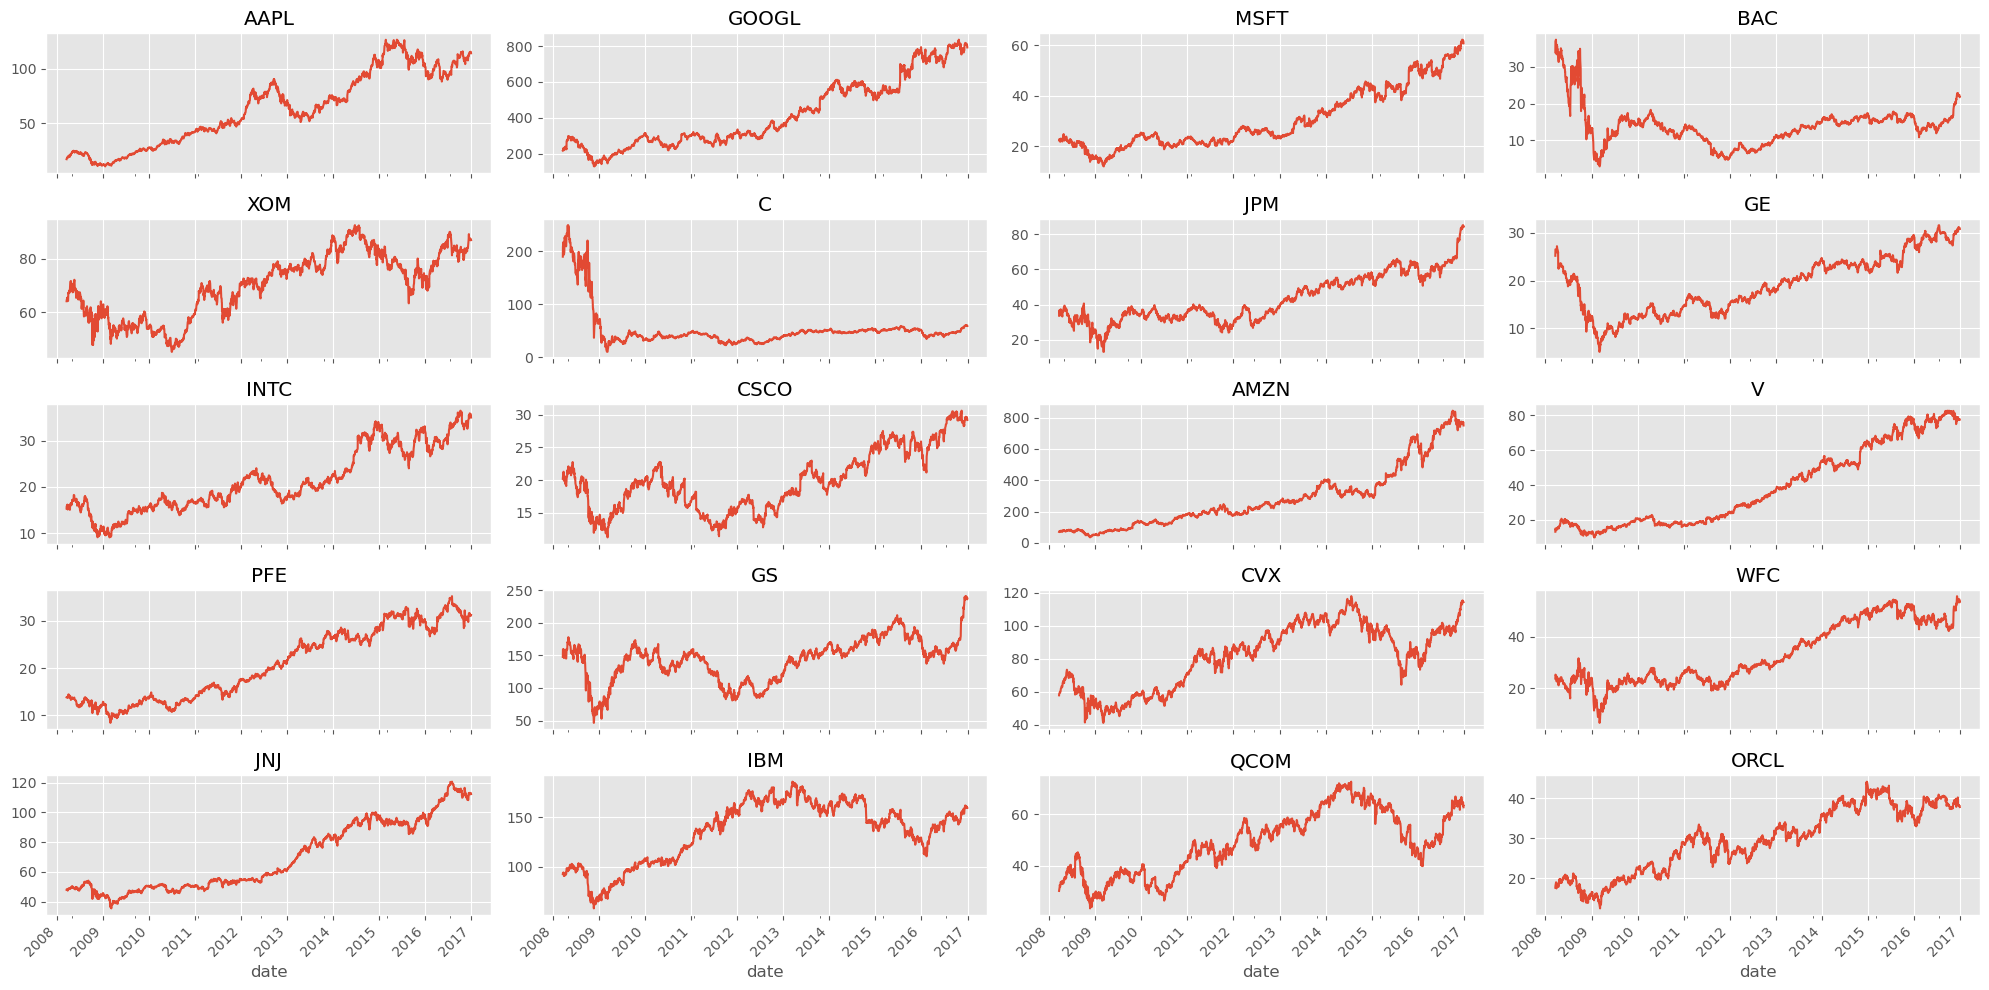

In [40]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, ticker in enumerate(list_of_ticker):

    ax = axes[i]
    close_prices[ticker].plot(ax=ax, title=ticker)
    ax.set_title(ticker)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.setp(ax.get_xticklabels(), rotation=45)
                 
                 

plt.tight_layout()                



# Alpha factors construction and  performance evaluation

### Alpha factor: 3-Day mean-reversion

We first build a raw  3-day mean-reversion alpha factor whose performance will be later evaluated on different holding periods using the python alphalens library

In [62]:
mean_reversion_raw_alpha = lambda df, num_days: -1*df.close.pct_change(num_days).unstack('ticker').dropna().stack('ticker')
mean_reversion_raw_alpha(universe, 3)

date        ticker
2008-03-19  AAPL     -0.024169
            GOOGL     0.013518
            MSFT     -0.023605
            BAC      -0.080415
            XOM       0.017227
                        ...   
2016-12-30  WFC       0.015013
            JNJ       0.006039
            IBM       0.006880
            QCOM      0.030483
            ORCL      0.009531
Length: 44280, dtype: float64

### Preprocessing Raw  Alpha Factor:

$\textbf{Market neutral}$: It is the process of demeaning an lapha vector and mainly consists of substracting the alpha vector mean from each alpha value so that each alpha vector mean sums up to zero. This will imply that general market movements affecting all stocks are cancelled out. It is also possible to neutralize the portfolio by sector to avoid the stocks to be exposed to overall movements within a sector, but that is out of scope here.


$\textbf{Ranking}$: This consists of ranking alpha signals  values according to their importance. It is a broadly used method in statistics to make calculation more robust and less sensitive to noise. In this context, it also helps to mitigate sensitivity to noise and outliers, and to avoid excessive trades that may impact transaction costs. 
To rank our alpha factor, we convert each alpha vector of decimal to an alpha vector of ranks where the highest rank is assigned to the highest numerical alpha value and the lowest rank to the lowest numerical alpha value.

$\textbf{Z-scoring}$: Commonly used in statistics to normlize a given dataset. To z-score an alpha vector, we calculate its mean and standard deviation first. Then for each alpha value, we substract the mean and  divide by the standard deviation. This will standardize the data so it has consistent range and distribution.



In [43]:
de_mean = lambda x: x - x.groupby('date').transform('mean')
ranking = lambda x: x.unstack('ticker').rank(axis=1, ascending=True).stack('ticker')
z_scoring = lambda x: (x.sub(x.groupby('date').transform('mean'))).div(x.groupby('date').transform('std'))

#### Class to build and preprocess the alpha factor

This class will build and process our alpha factor so that it will be ready to use for performance evaluation.

In [61]:
class BuildAlphaFactors(object):

    def __init__(self, df, num_days):

        self.raw_alpha_factor_ = mean_reversion_raw_alpha(df, num_days)
        self.demeaned_alpha_factor_ = de_mean(self.raw_alpha_factor_)
        self.ranked_alpha_factor_ = ranking(self.demeaned_alpha_factor_)
        self.zscored_alpha_factor_ = z_scoring(self.ranked_alpha_factor_)

        
_alpha_factor_ = BuildAlphaFactors(universe, num_days=3)
_alpha_factor_ = _alpha_factor_.zscored_alpha_factor_
_alpha_factor_

date        ticker
2008-03-19  AAPL     -0.253546
            GOOGL     0.929670
            MSFT     -0.084515
            BAC      -1.436762
            XOM       1.098701
                        ...   
2016-12-30  WFC       0.422577
            JNJ      -0.929670
            IBM      -0.760639
            QCOM      1.605793
            ORCL     -0.253546
Length: 44280, dtype: float64

## Evaluate alpha factors: alphalens 

In this section, we evaluate the performance of the alpha factor on different holding periods within the quintiles.

The holding periods are on the forward returns. 


This evaluation phase is indeed a necessary step, as it  helps decide whether or not the underlying alpha factor should be considered for ultimate steps in the process including backtesting. 

In [63]:
import alphalens as al

In [64]:
# preprocessing the alpha data
holding_periods = (1, 2, 3, 4, 5, 6)
quantiles = 5

alpha_data = al.utils.get_clean_factor_and_forward_returns(factor=_alpha_factor_,
                                                           prices=close_prices,
                                                           periods=holding_periods,
                                                           quantiles=quantiles)
                                                                                                                                                                                                                                                                                                                                                     

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [65]:
alpha_data

1D        2D        3D        4D        5D        6D  \
date       asset                                                               
2008-03-19 AAPL   0.027763  0.076039  0.087221  0.118686  0.081592  0.102877   
           GOOGL  0.003588  0.066111  0.043472  0.060625  0.027963  0.014074   
           MSFT   0.019567  0.019217  0.018169 -0.002096 -0.019916 -0.024808   
           BAC    0.085581  0.100882  0.062500  0.033195  0.002075 -0.012707   
           XOM    0.006751  0.018003  0.009120  0.021675  0.020964  0.009357   
...                    ...       ...       ...       ...       ...       ...   
2016-12-21 WFC    0.000718  0.004488  0.004308 -0.007001 -0.015617 -0.010770   
           JNJ    0.001127  0.005637  0.005203 -0.001821  0.001561 -0.000867   
           IBM   -0.001614 -0.003705 -0.001135 -0.006813 -0.004363 -0.008008   
           QCOM  -0.005956 -0.004467  0.001340 -0.020995 -0.016677 -0.029184   
           ORCL   0.003348 -0.001288 -0.000258 -0.003863 -0.003605 -0.009786   

                    factor  factor_quantile  
date       asset                             
2008-03-19 AAPL  -0.253546                3  
           GOOGL  0.929670                4  
           MSFT  -0.084515                3  
           BAC   -1.436762                1  
           XOM    1.098701                5  
...                    ...              ...  
2016-12-21 WFC   -0.084515                3  
           JNJ    0.929670                4  
           IBM    0.084515                3  
           QCOM  -0.422577                2  
           ORCL   1.267731                5  

[44160 rows x 8 columns]

#### Factor Forward Returns
Calculate the daily forward returns on different holding periods.

In [67]:
factor_returns = al.performance.factor_returns(alpha_data)
factor_returns

,1D,2D,3D,4D,5D,6D
date,,,,,,
2008-03-19,-0.015956,-0.016887,-0.005072,0.010150,0.012810,0.019074
2008-03-20,-0.007799,0.001499,0.016193,0.023864,0.031793,0.030608
2008-03-24,0.010000,0.020340,0.030018,0.034466,0.032509,0.006370
2008-03-25,0.006815,0.016307,0.017020,0.016805,0.002835,0.001766
2008-03-26,0.003412,-0.005190,-0.007689,0.006093,0.000284,0.002003
...,...,...,...,...,...,...
2016-12-15,0.005342,0.005209,0.003852,0.004543,0.006074,0.004943
2016-12-16,0.001906,0.000045,0.000482,0.000612,-0.001232,-0.000044
2016-12-19,0.000392,0.000206,-0.000962,-0.001385,-0.000581,-0.000728


Here we want to see the cumulative factor returns over time. We observe that longer holding periods yield higher factor returns.

This hints the idea of considering longer holding periods for investment with the underlying alpha strategy.

Text(0.5, 1.0, 'Factor Returns Over Time')

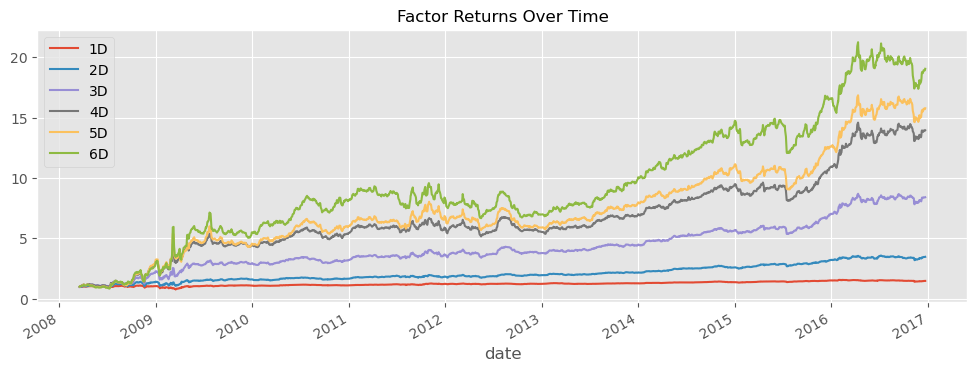

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
(1 + factor_returns).cumprod().plot(ax=axes)
axes.set_title('Factor Returns Over Time', fontsize=12)

#### Sharpe ratio

This is the ratio of reward to volatility. It is a metric used in trading to measure the performance (mean return) of our portfolio relative to its risk (volatility) on the considered holding periods.  We are going to calculate the annualized Sharpe ratio on daily forward returns, for each holding period.

In [70]:
sharpe_ratio = np.sqrt(252)*(factor_returns.mean()).div(factor_returns.std()).to_frame().rename(columns={0:'Sharpe Ratio'})
sharpe_ratio

,Sharpe Ratio
1D,0.425117
2D,0.889952
3D,1.227498
4D,1.310824
5D,1.272458
6D,1.265216


In [71]:
sharpe_ratio.round(2).values.flatten()

array([0.43, 0.89, 1.23, 1.31, 1.27, 1.27])

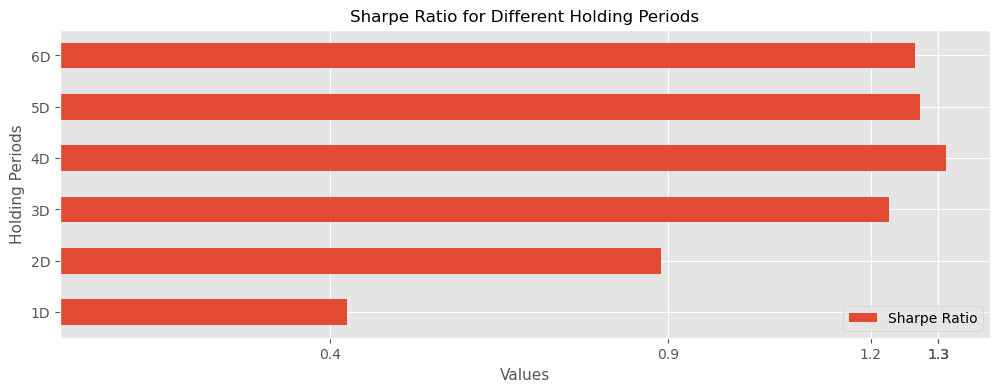

In [72]:
fig, ax = plt.subplots(figsize=(12, 4))
sharpe_ratio.plot.barh(ax = ax, linestyle='solid')
ax.set_xlabel('Values', fontsize=11)
ax.set_ylabel('Holding Periods', fontsize=11)
ax.set_title('Sharpe Ratio for Different Holding Periods', fontsize=12)
ax.set_xticks(sharpe_ratio.round(1).values.flatten())
ax.legend()
plt.show()

Sharpe ratios are all positive and on all holding periods . 

Besides, the best sharpe ratios range from $89\%$ to $127\%$ from 2D to 6D.

Note that a higher Sharpe ratio yield a potentially good trading strategy. In this fairly simple strategy, the Sharpe ratios observed from 3-day to 6-day holding periods are promising, as shown on the chart above.

### Quantile Analysis

Now, we look at the stocks forward returns by the quantiles and  appreciate the alpha model's predictive ability according to average returns in each quantile. We will then compute the mean of the forward returns for each holding period within each quantile.

For each day, we sort the stocks by their alpha value. The k highest values are put in the 5th group, the k lowest are put in the first group and so on for the 2nd 3rd and 4th k lowest group. In this way, we can keep track of the individual returns within each of the 5 groups ovrer a chosen time window. We then calculate the mean return within each group as well as the standard deviation. This procedure is called a `quantile analysis or quantile performance`.


- An ideal alpha model would be one where the group of stocks containing the highest alpha values for that day would also have the highest average return and possibly the highest risk-adjusted return.

- Similarly, the group of stocks containing the lowest alpha values would ideally have the lowest returns.

That means, the fifth group containing the highest alpha values would ideally yield the highest returns. There would also ideally be a smooth progresion down the fourth, third, second and first groups. That is a monotonically increasing of the mean retunrns from the first group to the fifth group. 

In [73]:
mean_ret_quantile, mean_std_quantile = al.performance.mean_return_by_quantile(alpha_data)
mean_ret_quantile

,1D,2D,3D,4D,5D,6D
factor_quantile,,,,,,
1,-0.000044,-0.000443,-0.000833,-0.001003,-0.001290,-0.001445
2,-0.000474,-0.000687,-0.001040,-0.001292,-0.001202,-0.001247
3,0.000089,-0.000129,-0.000141,-0.000310,-0.000195,-0.000281
4,0.000038,0.000143,0.000111,0.000381,0.000606,0.000722
5,0.000392,0.001114,0.001902,0.002223,0.002079,0.002251


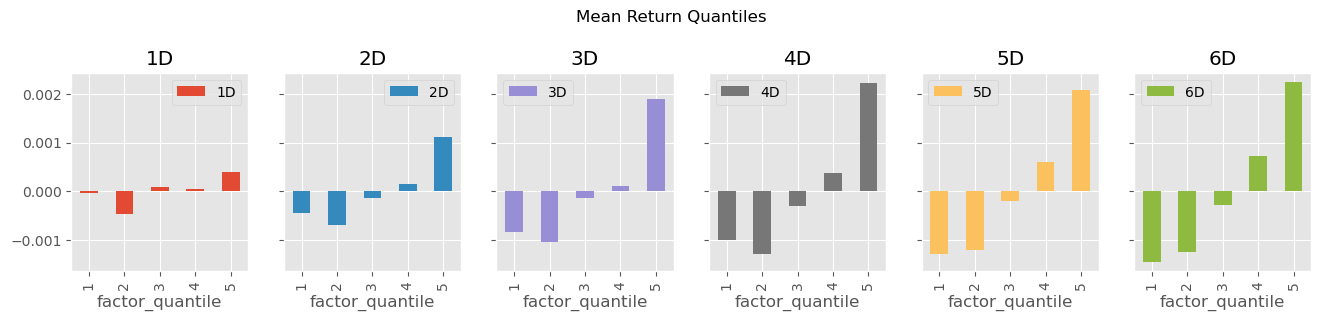

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(16, 3))
(mean_ret_quantile).plot.bar(subplots=True, ax=axes)

# Add a supertitle
fig.suptitle('Mean Return Quantiles', fontsize=12)
fig.subplots_adjust(top=.77)

plt.show()

Regarding the quantile-wise mean returns charts, we see that with the 5D and 6D holding periods, the first quantile has shown the lowest returns, while the fifth quantile has shown the highest return. There is also a gradual increase of the mean return from the first quantile to the fifth quantile.


With the 5D and 6D holding periods, our strategy has effectively differentiated between better-performing and worse-performing stocks

$\textbf{Strategy Evaluation:}$ The monotonic pattern of mean returns  accross quantiles suggests that the strategy is successful in ranking stocks according to their expected performance. That is, stocks predicted to perform well (higher quantiles) indeed yield higher returns, and those predicted to perform poorly (lower quantiles) yield lower or negative returns.

In [87]:
from alphalens.plotting import*

#### Cumulative Returns per Quantile:

We want to see the investment performance within each quintile over time.

For that we first compute the daily returns by quantile as opposed to the previous average returns by quantile. Then we visualize the evolution of cumulative returns in each quintile.


In [83]:
mean_ret_quantile_daily, mean_std_quantile_daily = al.performance.mean_return_by_quantile(alpha_data, by_date=True)

In [86]:
mean_ret_quantile_daily

1D        2D        3D        4D        5D  \
factor_quantile date                                                           
1               2008-03-19  0.036696  0.025801  0.012288 -0.010040 -0.016783   
                2008-03-20  0.000950 -0.009506 -0.035758 -0.039914 -0.051625   
                2008-03-24 -0.014175 -0.038606 -0.042608 -0.052271 -0.048571   
                2008-03-25 -0.003182 -0.003021 -0.001496 -0.002637  0.009364   
                2008-03-26 -0.016063 -0.004133 -0.002578 -0.005247 -0.006381   
...                              ...       ...       ...       ...       ...   
5               2016-12-15  0.006772  0.005000  0.005823  0.006473  0.007395   
                2016-12-16 -0.001105 -0.004600 -0.002476 -0.001773 -0.005617   
                2016-12-19 -0.000052 -0.000258 -0.000444 -0.001397 -0.002198   
                2016-12-20  0.001128 -0.000150 -0.000198 -0.000180 -0.002659   
                2016-12-21  0.003479  0.002800  0.002339  0.003949  0.007900   

                                  6D  
factor_quantile date                  
1               2008-03-19 -0.025497  
                2008-03-20 -0.051676  
                2008-03-24 -0.009044  
                2008-03-25  0.011420  
                2008-03-26 -0.004088  
...                              ...  
5               2016-12-15  0.008023  
                2016-12-16 -0.002689  
                2016-12-19 -0.000486  
                2016-12-20 -0.002714  
                2016-12-21  0.008325  

[11040 rows x 6 columns]

#### 1D Holding period

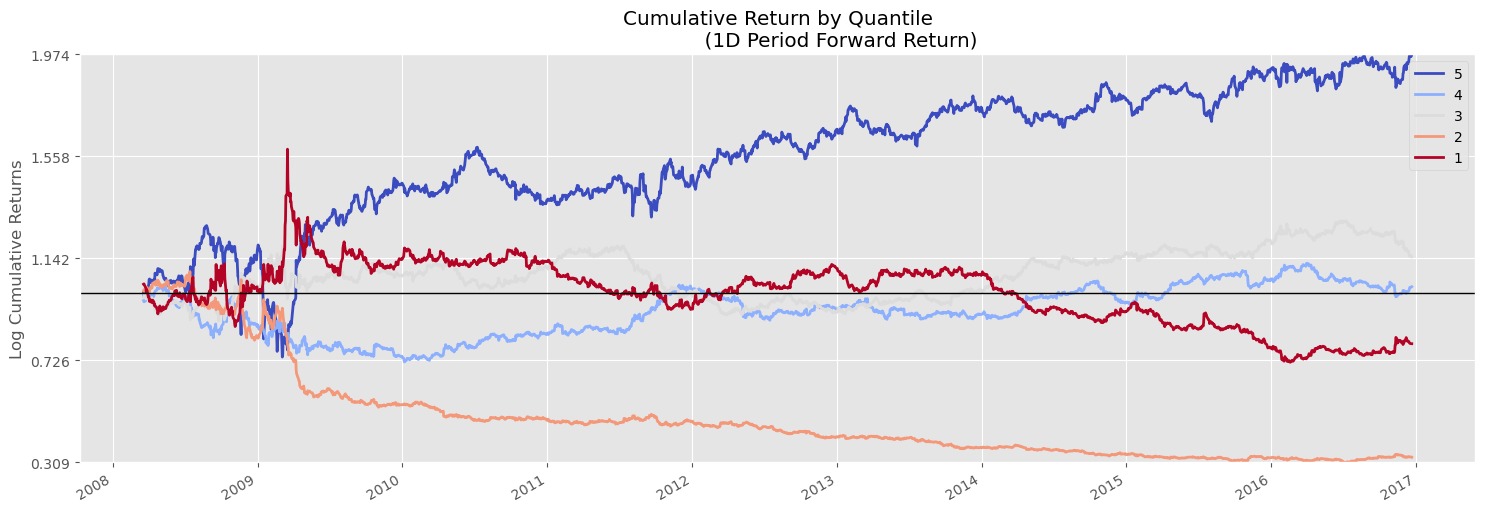

In [90]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['1D'], period='1D')
plt.show()

#### 2D Holding period

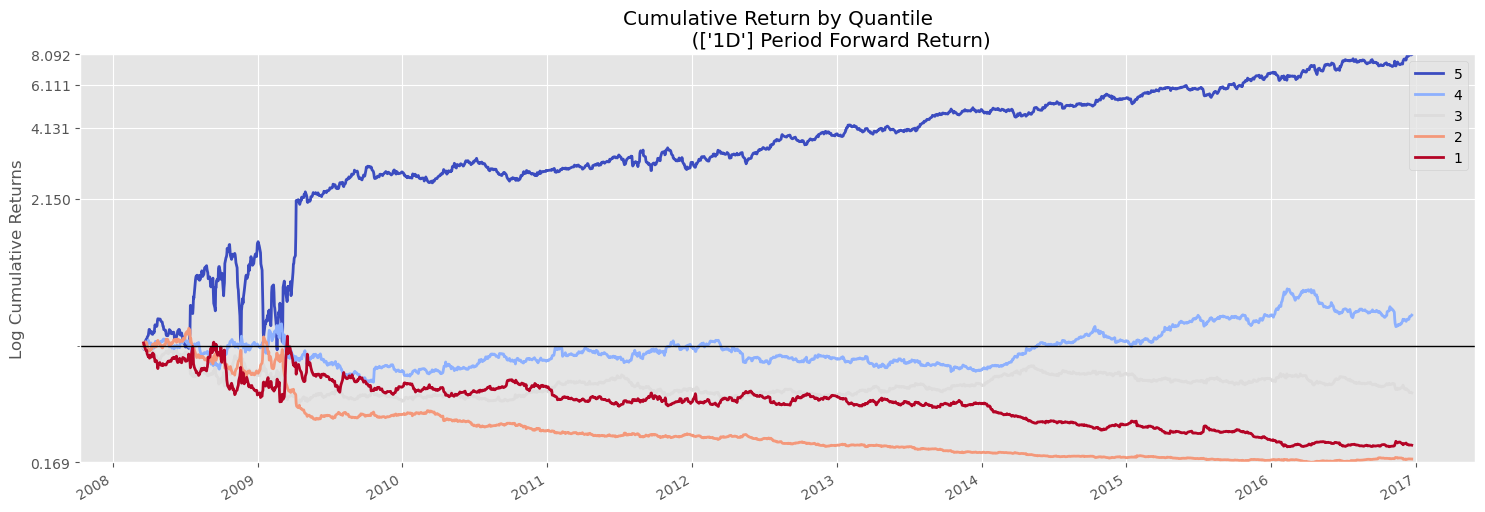

In [91]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['2D'], period=['1D']);

#### 3D Holding period

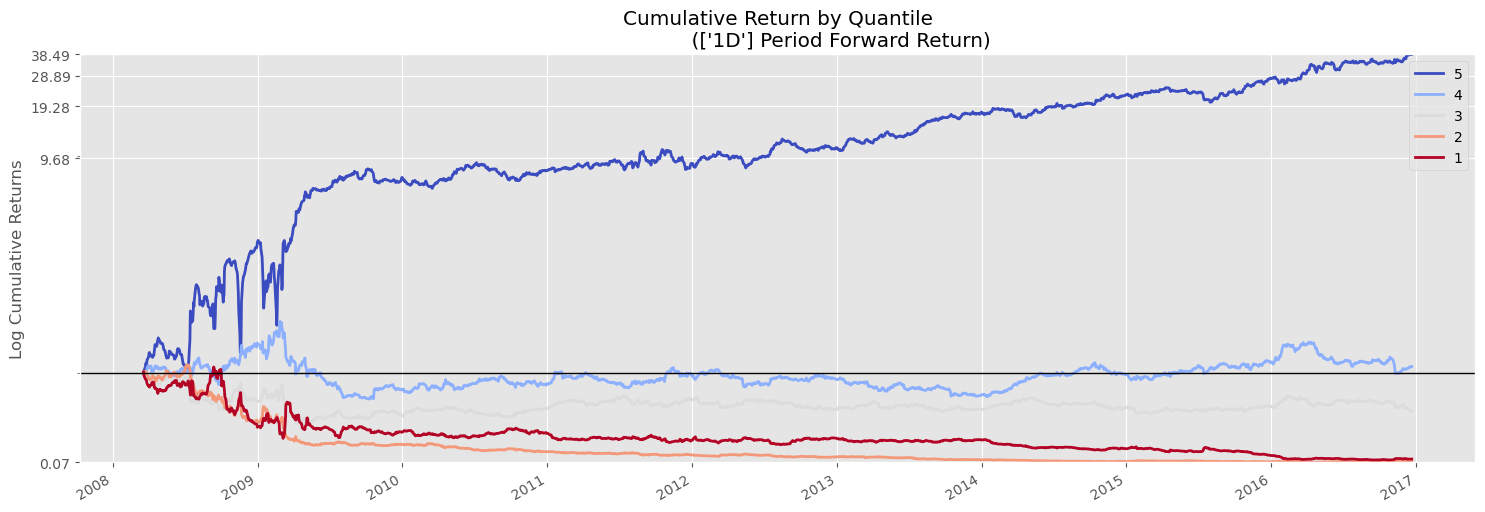

In [92]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['3D'], period=['1D']);

#### 4D Holding period

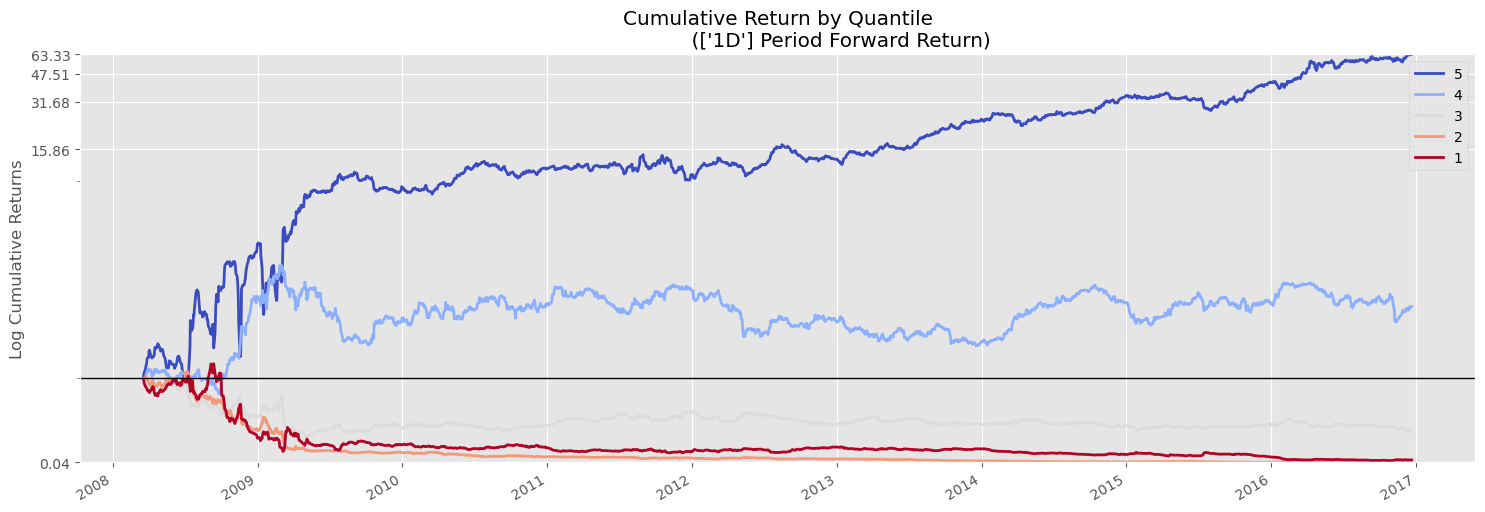

In [93]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['4D'], period=['1D']);

#### 5D Holding period

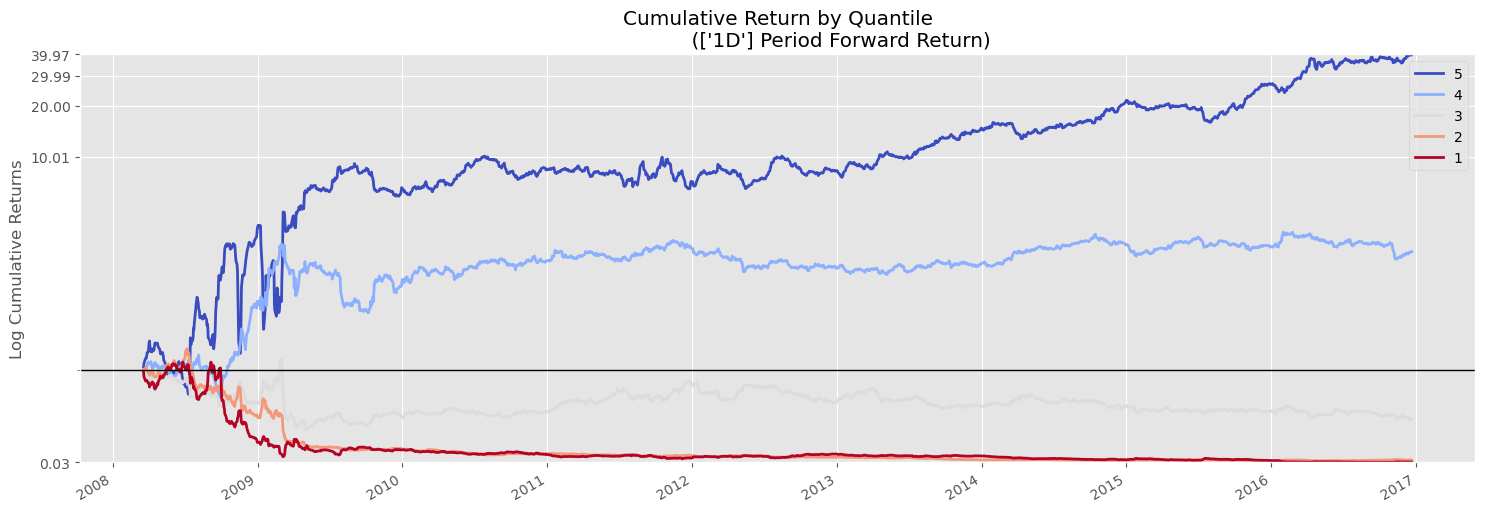

In [94]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['5D'], period=['1D']);

#### 6D Holding period

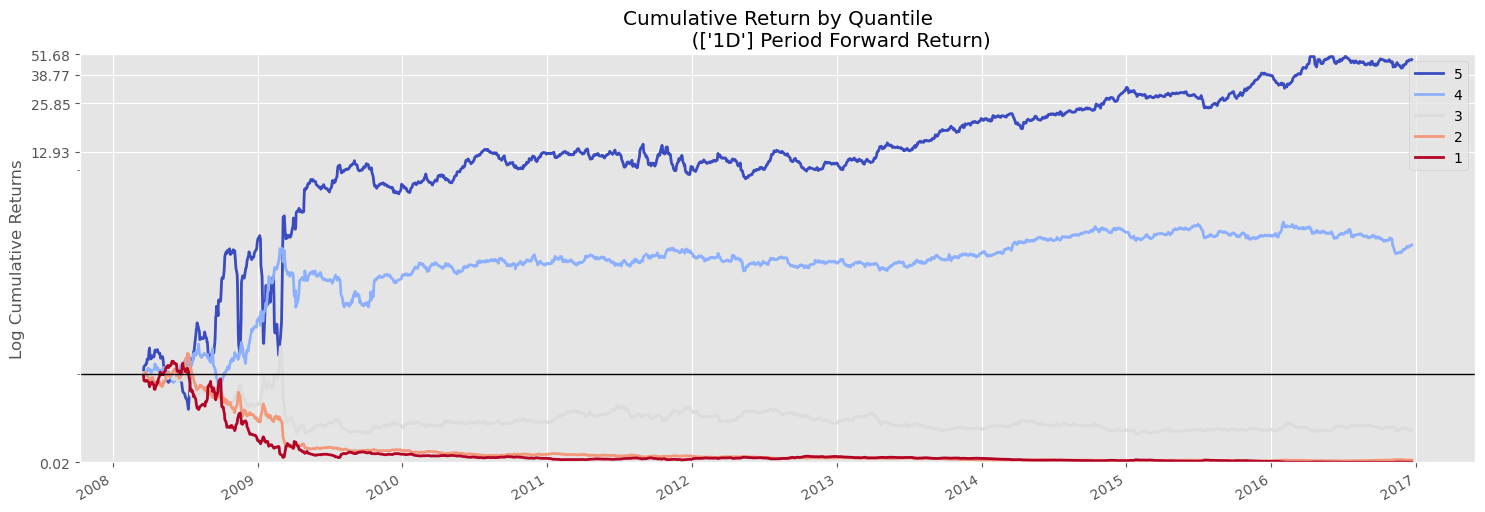

In [95]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['6D'], period=['1D']);

Considering the annualized Sharpe ratio, the charts show that the investment strategy is particularly promising with 5-Day, 6-Day and 4-Day holding period.

Indeed, the quantile-wise cumulative return plots have shown that, for those  holding periods, stocks in the highest quantile (those predicted to perform the best) show higher cumulative daily mean returns over time, which indicate that the alpha factor used to sort the stocks is effectively predictive. The same is true for the stocks in the lowest quantile(those that are being shorted).  They show lowest cumulative returns over time.  

Therefore, the 3-Day mean reversion alpha factor is predictive when applied on 6-Day, 5-Day and 4-Day  holding periods.

### Turnover Analysis

Without doing a full and formal backtest, we can for now analyze the stability of the alphas over time. Stability in this sense measures the change of the alpha vector period to period. Strong stabilty means stable vectors and hence stable positions that may not need to be closed.Indeed, trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

<Axes: xlabel='date'>

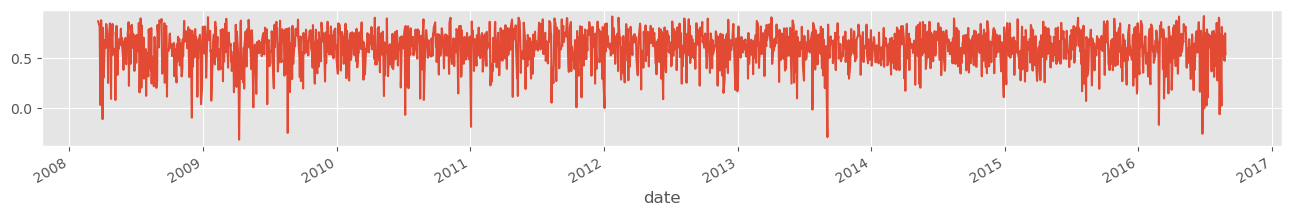

In [ ]:
alpha_factor_FRA = al.performance.factor_rank_autocorrelation(alpha_data)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 2))
alpha_factor_FRA.plot(ax=axes)


We can see a relatively high turnover, meaning that from day to day an alpha vector can change a lot implying more trade frequency. We would prefer to have a FRA that is pretty close to 1.

#### Information Coefficient (IC) 

We now evaluate the predictabibility of our alpha factor in different holding periods and denote the information coefficient (IC).  The IC tells us wether the alpha values are correlated with the future returns. In practice, we calculate it using the rank correlation by considering both the rank of the alpha values and the rank of the futur returs. 
Note that, in general, we use the ranks to avoid the influence of outliers on calculations, but here, most importantly because we do not care to be wrong in the right direction. 

Correlation of rank values is called Spearman rank correlation to be distinguished from the Pearson correlation. It is given by
$$\mathrm{rankCorr}(X, Y) = \frac{\mathrm{cov}(rank(X), rank(Y))}{\mathrm{std}(rank(X))\times \mathrm{std}(rank(Y))}$$

In [96]:
ic = al.performance.factor_information_coefficient(alpha_data)
ic

,1D,2D,3D,4D,5D,6D
date,,,,,,
2008-03-19,-0.523308,-0.419549,-0.171429,0.192481,0.224060,0.421053
2008-03-20,-0.105263,0.049624,0.512782,0.654135,0.726316,0.560902
2008-03-24,0.336842,0.562406,0.724812,0.700752,0.657143,0.320301
2008-03-25,0.282707,0.529323,0.393985,0.387970,0.187970,0.057143
2008-03-26,0.123308,-0.303759,-0.278195,0.112782,-0.103759,-0.103759
...,...,...,...,...,...,...
2016-12-15,0.487218,0.297744,0.240602,0.270677,0.386466,0.318797
2016-12-16,0.121805,-0.001504,0.006015,0.058647,-0.106767,-0.003008
2016-12-19,0.105263,-0.021053,-0.093233,-0.124812,-0.108271,0.012030


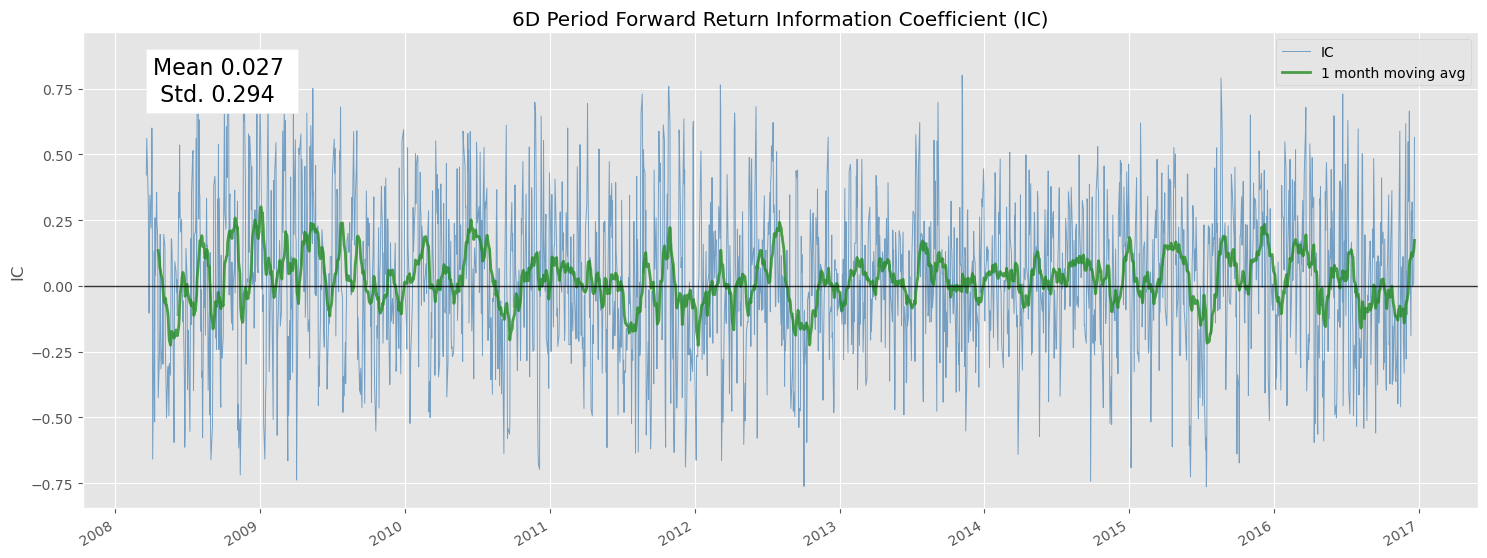

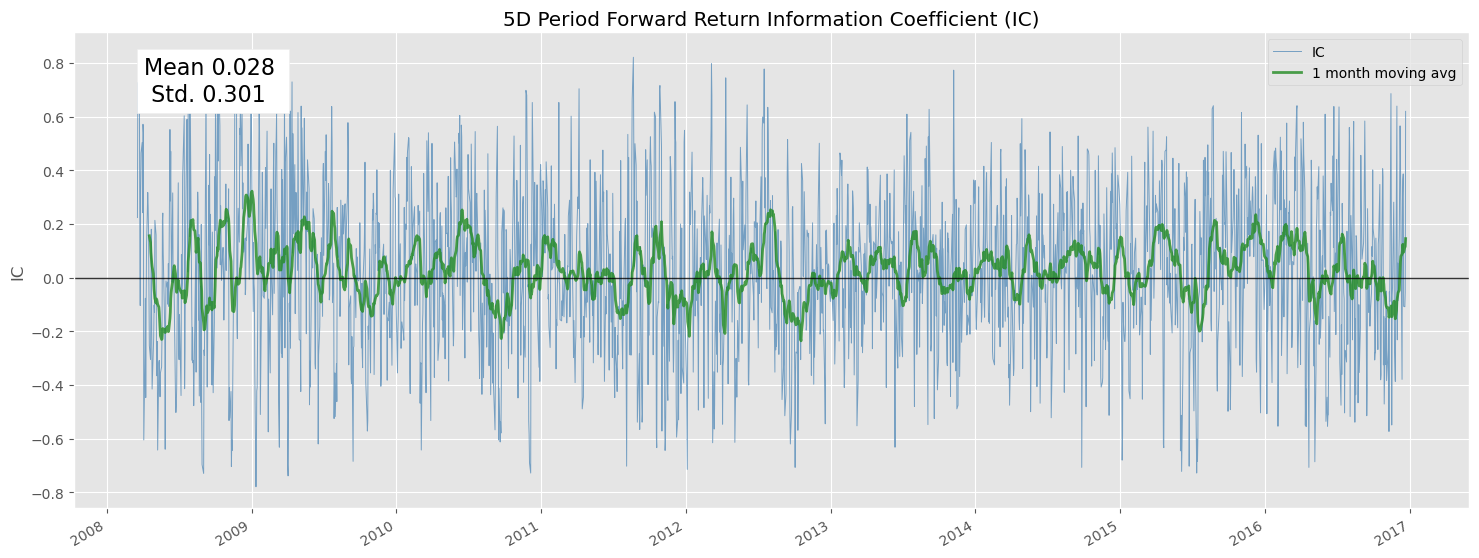

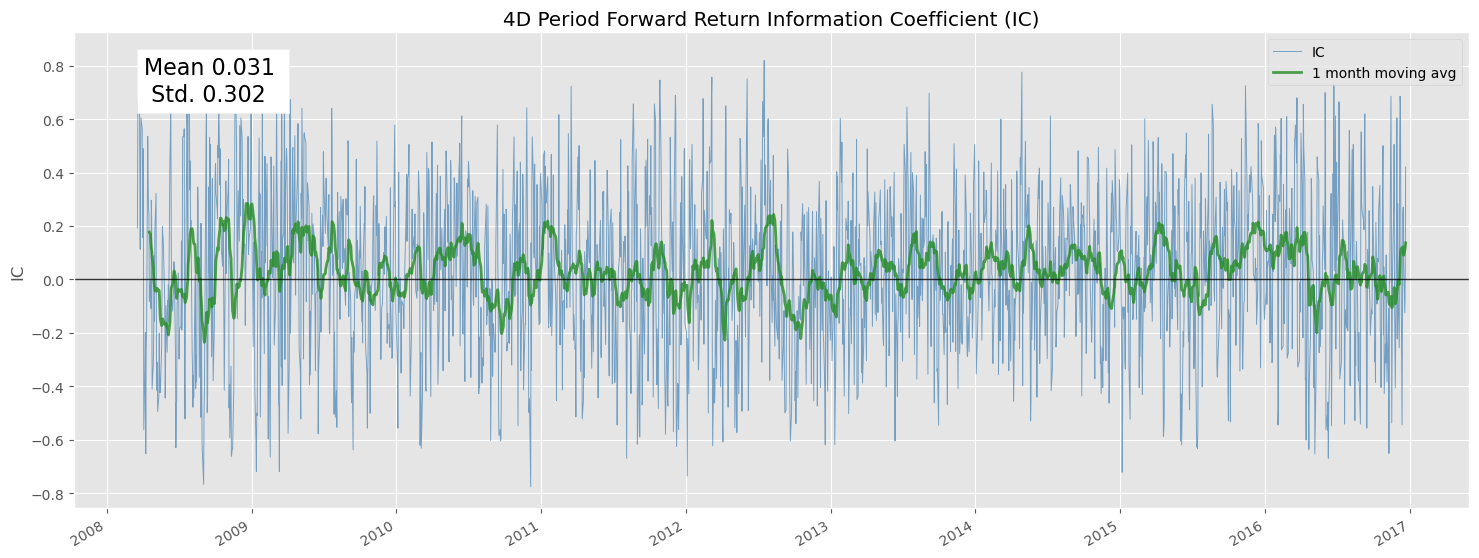

In [98]:
plot_ic_ts(ic[['6D']]);
plot_ic_ts(ic[['5D']]);
plot_ic_ts(ic[['4D']]);

The ICs are slightly tilted toward the positive side meaning that we have a postive mean correlation between alpha vectors and forward returns.

## Performance metrics summary statistics

Now we release a summary statistics of the trading stategy's performance

In [99]:
from alphalens.tears import*

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.606397,-1.098701,-1.352250,0.188993,8832,20.000000
2,-0.930019,-0.338189,-0.676077,0.189023,8833,20.002264
3,-0.253642,0.253642,0.000029,0.188959,8831,19.997736
4,0.422577,1.014567,0.676173,0.189015,8833,20.002264
5,1.098701,1.606397,1.352279,0.188985,8831,19.997736


Returns Analysis


,1D,2D,3D,4D,5D,6D
Ann. alpha,0.039,0.062,0.073,0.067,0.058,0.050
beta,0.093,0.126,0.126,0.126,0.098,0.101
Mean Period Wise Return Top Quantile (bps),3.917,5.570,6.337,5.552,4.154,3.748
Mean Period Wise Return Bottom Quantile (bps),-0.444,-2.216,-2.778,-2.507,-2.581,-2.410
Mean Period Wise Spread (bps),4.361,7.646,8.960,7.862,6.572,5.965


Information Analysis


,1D,2D,3D,4D,5D,6D
IC Mean,0.020,0.026,0.031,0.031,0.028,0.027
IC Std.,0.306,0.302,0.304,0.302,0.301,0.294
Risk-Adjusted IC,0.066,0.086,0.103,0.103,0.093,0.091
t-stat(IC),3.085,4.044,4.826,4.824,4.382,4.260
p-value(IC),0.002,0.000,0.000,0.000,0.000,0.000
IC Skew,0.060,0.005,-0.045,-0.062,-0.052,-0.023
IC Kurtosis,-0.434,-0.444,-0.392,-0.470,-0.393,-0.335


Turnover Analysis


,1D,2D,3D,4D,5D,6D
Quantile 1 Mean Turnover,0.465,0.650,0.791,0.794,0.790,0.792
Quantile 2 Mean Turnover,0.679,0.760,0.800,0.790,0.793,0.790
Quantile 3 Mean Turnover,0.707,0.769,0.780,0.781,0.789,0.784
Quantile 4 Mean Turnover,0.677,0.764,0.797,0.798,0.801,0.791
Quantile 5 Mean Turnover,0.469,0.652,0.791,0.787,0.781,0.777


,1D,2D,3D,4D,5D,6D
Mean Factor Rank Autocorrelation,0.588,0.266,-0.031,-0.024,-0.01,-0.006


<Figure size 640x480 with 0 Axes>

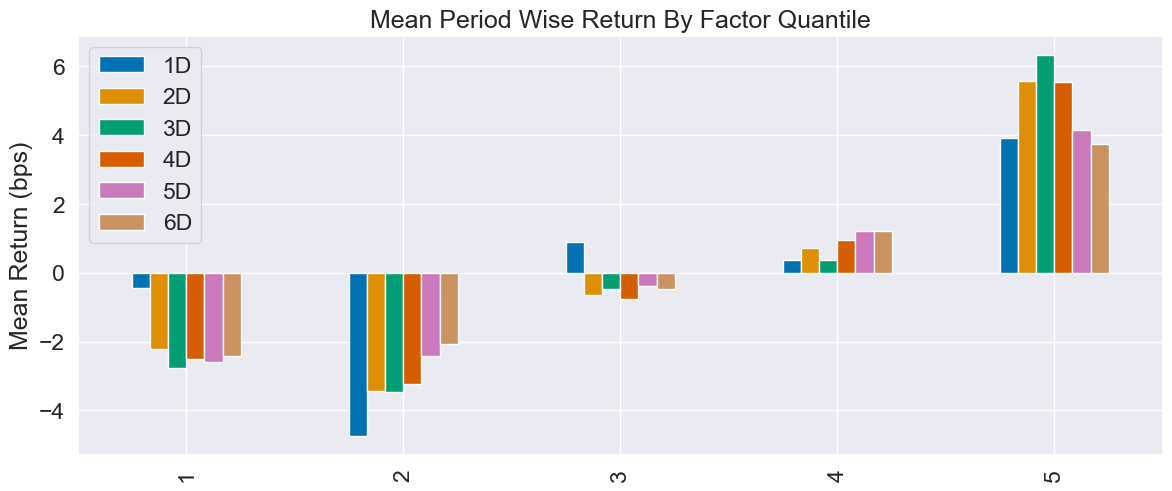

In [100]:
create_summary_tear_sheet(alpha_data)

## Returns Analysis:

Ann. alpha measures our strategy's performance relative to the benchmark (say S&P500) for different holding periods, independant of the market's movements.

Basic Formula: 

$\alpha = R_p - (R_f + \beta\times (R_m - R_f))\\$
Alpha ($\alpha$)  is a measure of the portfolio's performance on a risk-adjusted basis. It shows how much excess return the portfolio has generated compared to what would be expected based on its beta and the market return.

A positive alpha indicates that the portfolio has outperformed the market, given its level of risk (as measured by beta), while a negative alpha suggests underperformance.

The term $(R_f + \beta\times (R_m - R_f))$ represents the expected return of the portfolio based on its beta and the market's excess return over the risk-free rate. Subtracting this from the actual portfolio return ($R_p$) isolates the return attributable to the skill of the portfolio manager or the effectiveness of the investment strategy, independent of market movements.

$R_p = \text{Portfolio returns}$

$R_f = \text{Risk free rate}$

$R_m = \text{Benchmark (market) return}$

$\beta = \frac{\mathrm{Cov}(R_p, R_m)}{\mathrm{Var}(R_m)}=$  The beta of the portfolio measures the portfolio volatility compared to the benchmark market. 

A Beta of $1$ means the portfolio will move with the benchmark. 

A Beta less than $1$ means the portfolio is theoretically less volatile than the market, and vice versa.

## Information Coefficient analysis:

 The IC tells us wether the alpha values are correlated with the future returns. In practice, we calculate it using the rank correlation by considering both the rank of the alpha values and the rank of the futur returs. 
Note that, in general, we use the ranks to avoid the influence of outliers on calculations, but here, most importantly because we do not care to be wrong in the right direction. 

Correlation of rank values is called Spearman rank correlation to be distinguished from the Pearson correlation. It is given by
$$\mathrm{rankCorr}(X, Y) = \frac{\mathrm{cov}(rank(X), rank(Y))}{\mathrm{std}(rank(X))\times \mathrm{std}(rank(Y))}$$


IC Mean: The average value of the Information Coefficient (IC) over different periods. Recall that the IC measures the correlation between predicted and actual stock returns. Therefore, a positive IC indicates that the predictions made by our alpha factor are accurate in average (this is the case for all holding periods), while a negative IC suggests poor predictions. 

IC Std. (Standard Deviation): This shows the variability or dispersion of the IC values around the IC mean. A higher standard deviation implies more variability in the prediction accuracy. We can see that the IC standard deviation is almost constant over the periods.

Risk-Adjusted IC: Adjusts the IC for the risk (standard deviation) involved. It's essentially the IC Mean divided by the IC Standard Deviation.  

t-stat(IC): The t-statistic for the IC. It indicates whether the IC is statistically significantly different from zero. Higher absolute values suggest greater statistical significance.

p-value(IC): Represents the probability that the IC is different from zero purely by chance. A lower p-value (typically <0.05) suggests that the IC is statistically significant. A higher p-value suggests that we may be observing a non-zero IC just by chance or by some random fluctuations. 


The null hypothesis:

"The Information Coefficient (IC) has no predictive power."

This means that there is no correlation between the predicted returns from our alpha model and the actual returns.
Regarding the results, we can see that the t-statistic increases and the p-value decreases over longer periods, suggesting that the factor becomes statistically more significant for longer holding periods. In particular, for a level of significance $\alpha=0.05$, the null hypothesis is only rejected in the 4-day period, where we can argue that the IC does have a predictive power since it is statistically significant. 


IC Skew: Measures the asymmetry of the distribution of IC values. A skewness close to zero indicates a symmetrical distribution. Positive skew indicates a distribution with a longer tail on the right, while negative skew has a longer tail on the left.

IC Kurtosis: Measures the 'tailedness' of the IC distribution. A negative kurtosis indicates a distribution that is flatter than a normal distribution (less extreme values).


Conclusion
This analysis suggests that the factor being studied has better predictive power and statistical significance over longer holding periods (4D, 5D and 6D). The relatively high standard deviation of the IC across all periods indicates a considerable amount of variability in the factor's predictive accuracy. The skewness and kurtosis values suggest a fairly symmetric but flatter distribution of IC values, implying fewer extreme outliers in prediction errors.


## Turnover Analysis
The data provides Turnover Analysis for different quantiles over the various holding periods (1D, 2D, 3D, 4D, 5D, 6D). Recall that the turnover refers to how frequently assets within a portfolio or quintiles are bought and sold, meaning the proportions of assets that have left or joinded the quintile.

Increasing Turnover with Holding Period: 

For each quantile, the turnover tends to increase with the length of the holding period. This is a typical pattern, as holding assets for longer periods naturally leads to higher turnover rates.

Variation Across Quantiles: 

Different quantiles show different turnover behaviors. For example: Quantiles 1 and 5, which represent the extreme ends of the factor scoring, have lower turnover rates compared to the middle quantiles.
Quantiles 2, 3, and 4 exhibit higher turnover rates. This might indicate more frequent trading in these groups, possibly due to more significant price movements.


## Factor Rank Autocorrelation:

1D (1-Day) Autocorrelation (0.588): This suggests that the factor ranks are consistent in average from one day to the next. In other words, if a stock is ranked high based on a certain factor today, there is a probability of 1/2 to maintain a similar rank the next day.

3D, 4D,	5D,	6D Autocorrelations (-0.031,	-0.024,	-0.01,	-0.006): As the time lag increases (3 days, 4 days, 5 days, 6 days), the autocorrelations become negative. This implies that the factor ranks are not consistent over longer periods. The ranks of stocks based on the factor are more likely to change over these extended time frames, suggesting high trading activies when longer holding periods are considered.

# Conclusion 


 
 In this work I have build a 3-day mean-reverison alpha factor from historical data by following a typical algorithmic trading framework. The alpha factor has been evaluate on various performance metrics.

 I have shown that the simple 3-Day mean reversion alpha factor has better predictive power and statistical significance over longer holding periods (4, 5D, and 6D).
 
 Note that this is only one step among others in the task of finding effective alpha factors using algorithmic trading. 
 
 Even though this mean-reversion alpha factor is only chosen for training purpose, the framework used here is relevant for any numerical alpha factor. Combination with other alpha factors in order may also enhance performance.
